In [53]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

### 前置知识:
    建模类侧信道攻击: 
    
\begin{align}

MI(\textbf{L};K) & = H(K) - H(K|\textbf{L}) 
=E(-\log Pr(k)) - E(-\log Pr(K|\textbf{L} ) \\
& = \left(-\sum_{k \ in \mathcal{K}} Pr(k) \log Pr(k) \right) - \left ( - \sum _{k \in \mathcal{K}, \textbf{l} \in 
\mathcal{L}} Pr(k, \textbf{l}) \log Pr(k|\textbf{l})  \right )

\end{align}

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import norm, entropy
import scipy.stats as ss
from sklearn.model_selection import KFold

In [55]:
number_bits=2
number_classes=2**number_bits #the total number of values taken by the target intermediate

#setting the probability of the key
p_k= np.ones(number_classes, dtype=np.float64)
p_k/=number_classes


#defining the values for p(l|k), for the 4 different values of k
norm_params = np.array([[1, 4],[0,2], [0, 5], [-1, 4]]) # 均值与方差
#norm_params = np.array([[0, 0.1],[1, .1],[2, .1], [3, .1]])

In [56]:
def measure_data(p_k,norm_params,number_samples=100):
    """ 
    p_k = discrete probability distribution if K
    norm_params = parameters of the true distributions
    number_samples = number of samples for each class of K. This corresponds to n^k_p

    returns leakage samples correponding to the target intermediate K and norm_params
    """
    data = {}
    for k, _ in enumerate(p_k):
        data[k]= ss.norm.rvs(*(norm_params[k]),size=number_samples)
    return data

true_data=measure_data(p_k, norm_params)

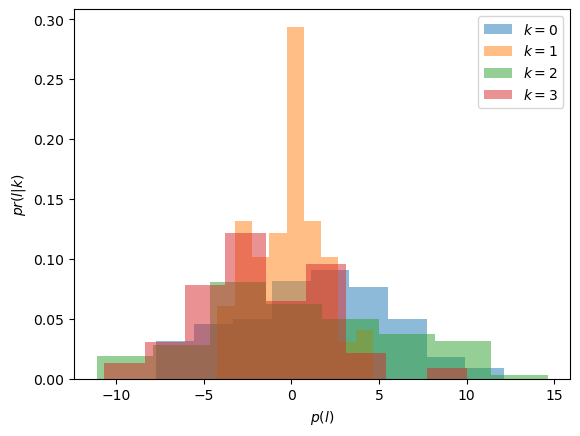

In [57]:
def visualize_distribution_points(data_dictionary, b='auto'):
    """
    plot the histogram of the elements in the lists
    as a function of the key values
    
    data_dictionary =  dictionary of lists, the key is the value of the keys and values are the samples l
                    = k: [l_0,l_1,....l_n]
    
    """
    for k in data_dictionary:

        plt.hist(data_dictionary[k], bins=b,density=True,alpha = 0.5,label='$k = %d$'%k)
    plt.xlabel("$p(l)$")
    plt.ylabel("$pr(l|k)$")
    plt.legend()
    plt.show()

visualize_distribution_points(true_data)

In [ ]:
def information(p_k, p_l_k):
    """
    implements I(K;L)
    
    p_k = the distribution of the sensitive variable K
    data = the samples we 'measured'. It its the n^k_p samples from p(l|k)
    model = the estimated model \hat{p}(l|k).riable) p_k_l: 

    returns an estimated of mutual information
    """
    k_list = len(p_k)              #N_k is the number of possible values for $K$
    acc = entropy(p_k,base=2)   #we initialize the value with H(K)
    for k in range(k_list):
        this_p_l_k = p_l_k[k]
        p_l=np.sum(p_k*(this_p_l_k).T,axis=1)
        p_k_l = p_k[k]*this_p_l_k[k,:]/ p_l
        acc += p_k[k] * np.mean(np.log2(p_k_l))
    return acc
# p_k = k的概率
# norm_params 分类器
# data 能量迹

# TODO: 这里plk就是算了所有密钥对应的概率 
data=measure_data(p_k, norm_params, number_samples=10000)
p_l_k = np.zeros((len(p_k), len(p_k), len(data[1])))
for i in range(len(p_k)):
    for k_star in range(len(p_k)):
        p_l_k[i, k_star,:] = ss.norm.pdf(data[i],*(norm_params[k_star]))
MI = information(p_k, p_l_k)
print("MI is %f"%(MI))

MI is 0.146376


In [ ]:
def information(p_k,data,model):
    """
    implements I(K;L)
    
    p_k = the distribution of the sensitive variable K
    data = the samples we 'measured'. It its the n^k_p samples from p(l|k)
    model = the estimated model \hat{p}(l|k).

    returns an estimated of mutual information
    """
    N_k = len(p_k)              #N_k is the number of possible values for $K$
    acc = entropy(p_k,base=2)   #we initialize the value with H(K)
    for k in range(N_k):
        l = data[k]
        p_l_k = np.zeros((N_k,len(l)))
        for k_star in range(N_k):
            p_l_k[k_star,:] = ss.norm.pdf(l,*(model[k_star]))
        p_l=np.sum(p_k*(p_l_k).T,axis=1)
        p_k_l =  p_k[k]*p_l_k[k,:]/ p_l
        acc += p_k[k] * np.mean(np.log2(p_k_l))
    return acc
import statsmodels.api as sm

data=measure_data(p_k, norm_params, number_samples=10000)
MI = information(p_k,data,norm_params)
print("MI is %f"%(MI))

2.0
MI is 0.144736


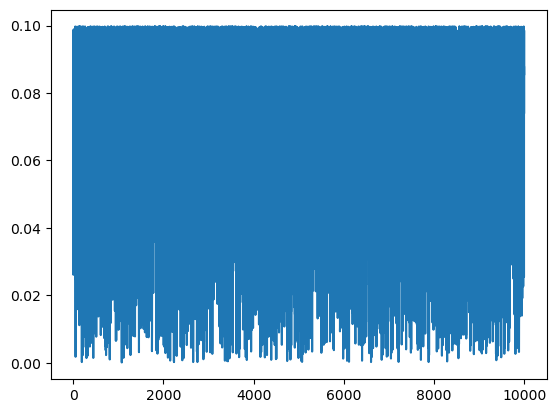

In [37]:
plt.plot(ss.norm.pdf(data[0],*(norm_params[0])))

In [38]:
N_s= 1000
n_fold = 10
N_av = 50

def keep_measures(p_k,data_orig,I):
    """ p_k: discrete probability distribution if K
        data_orig: set from which we select samples
        I: the indexes of the measures to keep

        returns a slice of data_orig
    """
    data = [data_orig[k][I] for k in range(len(p_k))]
    return data

### Generate data
data=measure_data(p_k, norm_params,number_samples=100000)

# data are exactly the one from the model, 
# this can not be done in real settings because norm_params are unkown
MI = information(p_k,data,norm_params)

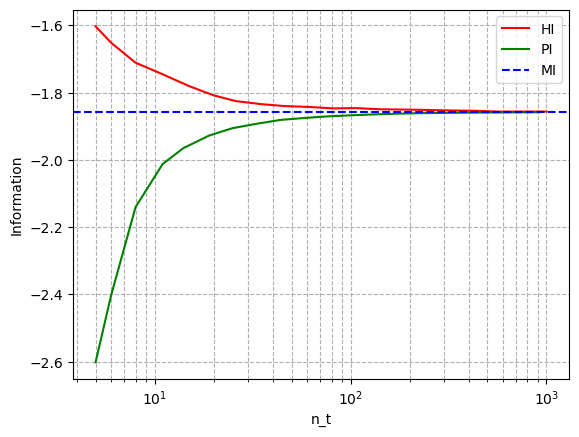

In [39]:
# Estimating PI and HI for various sampling efforts
N_HI = np.logspace(np.log10(5),np.log10(N_s),20,dtype=int)
N_PI = np.logspace(np.log10(5),np.log10(N_s*(1-1/n_fold)),20,dtype=int)
PI = np.zeros(len(N_HI))
HI = np.zeros(len(N_PI))
kf = KFold(n_splits=n_fold)


for av in range(N_av):
    # fresh data to compute the HI and PI on
    data = measure_data(p_k, norm_params,number_samples=N_HI[-1])
    
    #HI
    for i,n_p in enumerate(N_HI):
        # Keep the n first data samples
        data_n = keep_measures(p_k=p_k,data_orig=data,I=np.arange(n_p))
        
        #estimate model with n samples
        esti_models = [None for i in p_k]
        for k in range(len(p_k)):
            esti_models[k] = [np.mean(data_n[k]),np.std(data_n[k])]
        HI[i] += information(p_k,data_n,esti_models)

    #PI
    PI_x = np.zeros(PI.shape)
    for train_index, test_index in kf.split(range(N_s)):
        data_model = keep_measures(p_k=p_k,data_orig=data,I=train_index)
        data_p = keep_measures(p_k=p_k,data_orig=data,I=test_index)

        for i,n in enumerate(N_PI):
            data_model_nt = keep_measures(p_k=p_k,data_orig=data_model,I=range(n))
    
            #generate fresh samples
            esti_models = [None for i in p_k]
            for k in range(len(p_k)):
                esti_models[k] = [np.mean(data_model_nt[k]),np.std(data_model_nt[k])]
            PI_x[i] += information(p_k,data_p,esti_models)
    PI += PI_x/n_fold
HI /= N_av
PI /= N_av

#visualize plots
plt.figure()
plt.semilogx(N_HI,HI,label="HI",color="r")
plt.semilogx(N_PI,PI,label="PI",color="g")
plt.axhline(MI,label="MI",color="b",ls="--")
plt.grid(True,which="both",ls="--")
plt.xlabel("n_t")
plt.ylabel("Information")
plt.legend()
plt.show()